--- PART A: RUNNING CLUSTERING (PURE STATS) ---
               Apps  Trophies Won  No. of Clubs  PPG All Time  \
Cluster                                                         
0        375.365854      2.024390      7.658537      1.502195   
1        282.266667      1.266667      3.906667      1.580400   
2        517.035714     13.928571      4.428571      1.687143   
3         20.432432      0.027027      0.270270      1.528649   

        Dominant Position  Count  
Cluster                           
0              Midfielder     41  
1              Midfielder     75  
2              Midfielder     28  
3                       0     37  


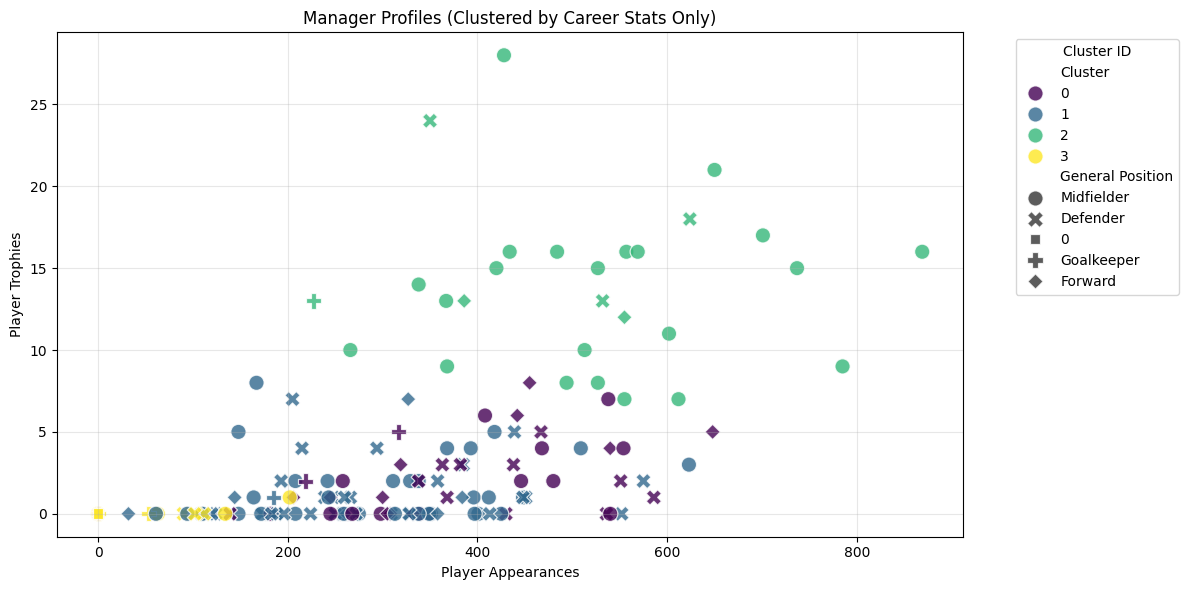

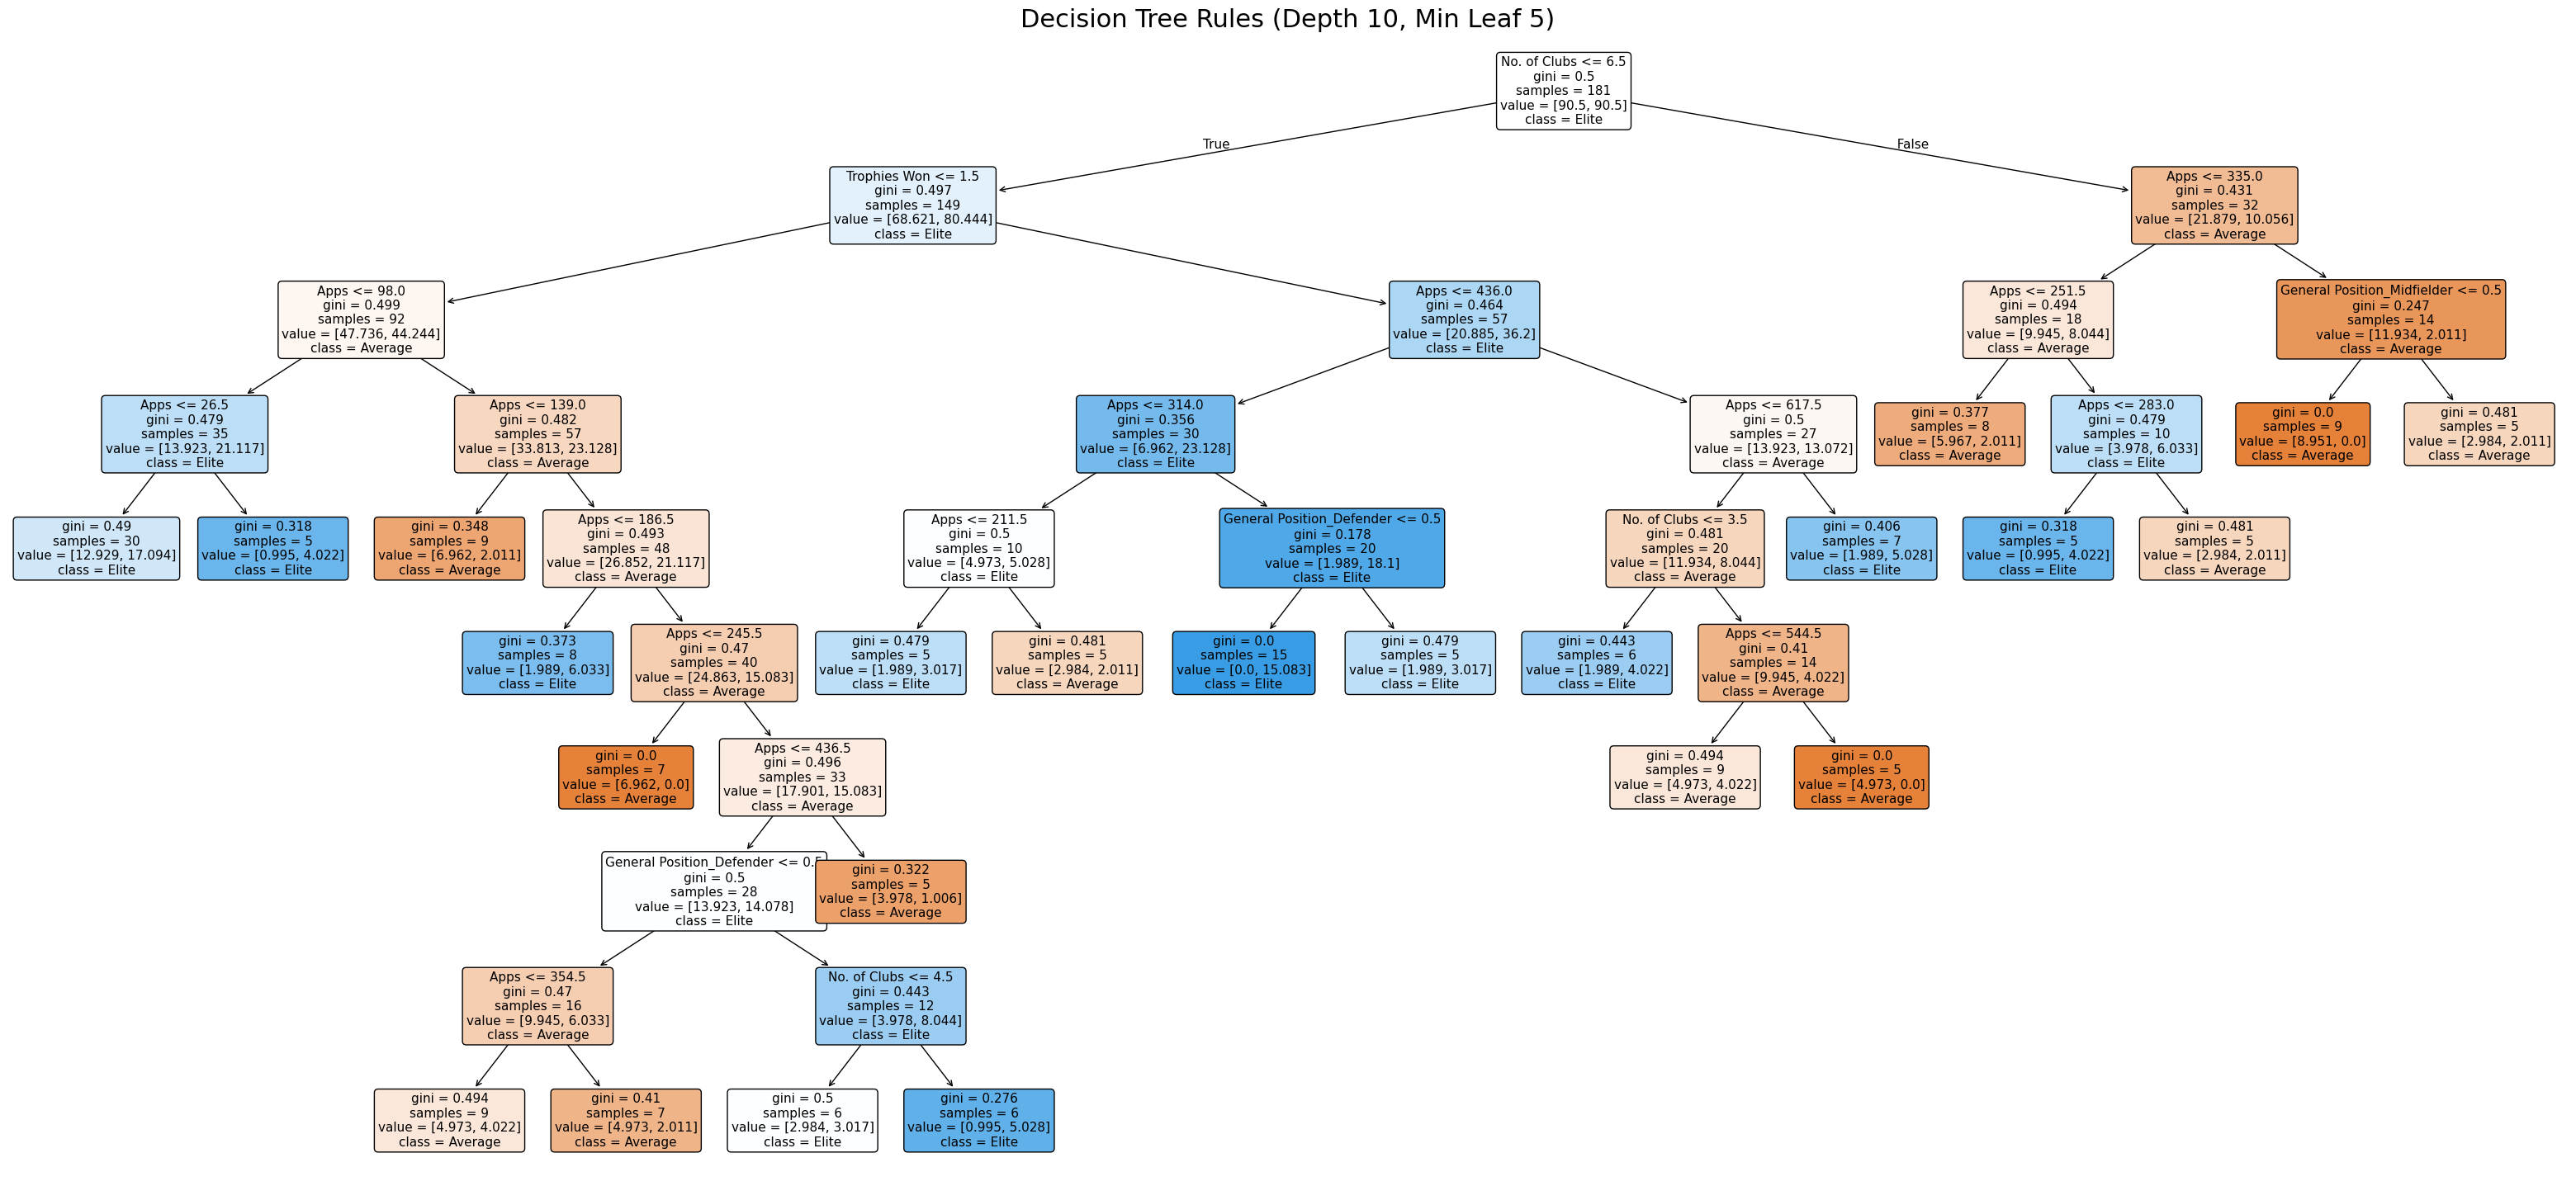

/tmp/ipython-input-428442956.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


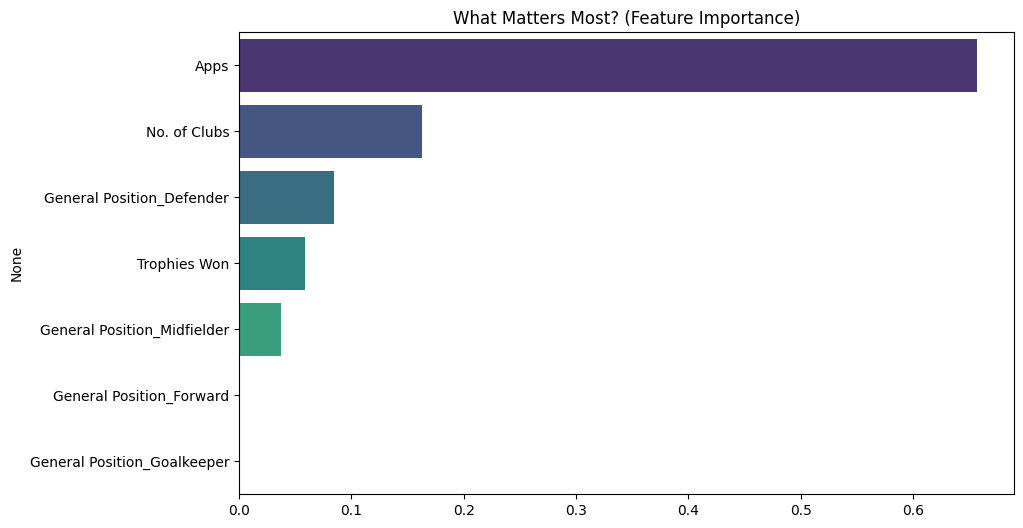

<Figure size 800x600 with 0 Axes>

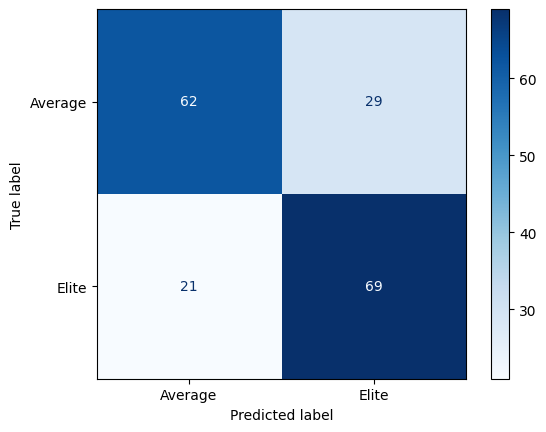

Decision Tree Accuracy: 0.72


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("dsa210_merged_data.csv")


print("--- PART A: RUNNING CLUSTERING (PURE STATS) ---")


df_cluster = df.dropna(subset=['Apps', 'Trophies Won', 'No. of Clubs', 'General Position']).copy()

cluster_features = ['Apps', 'Trophies Won', 'No. of Clubs']
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(df_cluster[cluster_features])

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(X_cluster_scaled)
cluster_summary = df_cluster.groupby('Cluster')[['Apps', 'Trophies Won', 'No. of Clubs', 'PPG All Time']].mean()
cluster_summary['Dominant Position'] = df_cluster.groupby('Cluster')['General Position'].agg(lambda x: x.mode()[0])
cluster_summary['Count'] = df_cluster['Cluster'].value_counts()

print(cluster_summary)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_cluster,
    x='Apps',
    y='Trophies Won',
    hue='Cluster',
    style='General Position',
    palette='viridis',
    s=120,
    alpha=0.8
)

plt.title('Manager Profiles (Clustered by Career Stats Only)')
plt.xlabel('Player Appearances')
plt.ylabel('Player Trophies')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster ID")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


df_class = df.copy()
df_class_encoded = pd.get_dummies(df_class, columns=['General Position'], drop_first=False)
median_ppg = df_class['PPG All Time'].median()
df_class_encoded['is_elite'] = (df_class_encoded['PPG All Time'] > median_ppg).astype(int)

features_class = [
    'Apps', 'Trophies Won', 'No. of Clubs',
    'General Position_Defender', 'General Position_Forward',
    'General Position_Goalkeeper', 'General Position_Midfielder'
]
X_class = df_class_encoded[features_class]
y_class = df_class_encoded['is_elite']

clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42, class_weight='balanced')
clf.fit(X_class, y_class)

# Tree Visualization
plt.figure(figsize=(40, 18))
plot_tree(clf, feature_names=features_class, class_names=['Average', 'Elite'], filled=True, rounded=True, fontsize=11)
plt.title(f"Decision Tree Rules (Depth 10, Min Leaf 5)", fontsize=22)
plt.show()

# Feature Importance
importances = pd.Series(clf.feature_importances_, index=features_class).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("What Matters Most? (Feature Importance)")
plt.show()

# Confusion Matrix
y_pred = clf.predict(X_class)
cm = confusion_matrix(y_class, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Average', 'Elite'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.show()

print(f"Decision Tree Accuracy: {accuracy_score(y_class, y_pred):.2f}")

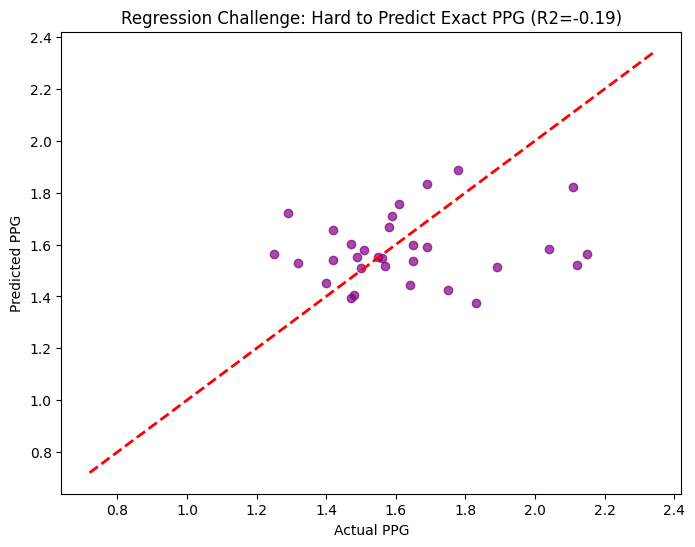

/tmp/ipython-input-2026086489.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='magma')


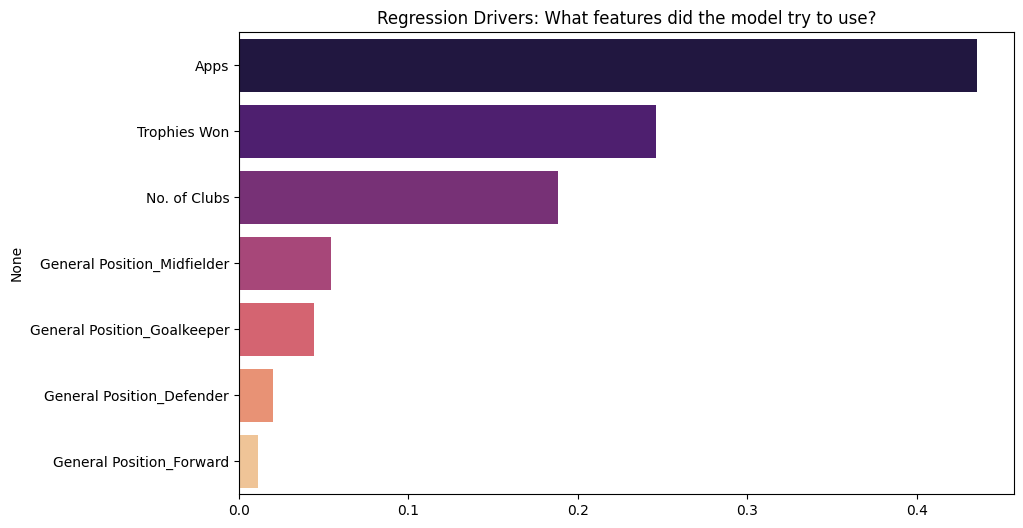

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv("dsa210_merged_data.csv")

df_reg = df.dropna(subset=['Apps', 'Trophies Won', 'No. of Clubs', 'PPG All Time', 'General Position']).copy()
df_reg = df_reg[df_reg['General Position'] != '0']
df_encoded = pd.get_dummies(df_reg, columns=['General Position'], drop_first=False)

features = [
    'Apps',
    'Trophies Won',
    'No. of Clubs',
    'General Position_Defender',
    'General Position_Forward',
    'General Position_Goalkeeper',
    'General Position_Midfielder'
]
X = df_encoded[features]
y = df_encoded['PPG All Time']

# TRAIN RANDOM FOREST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# VISUALIZATION: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual PPG")
plt.ylabel("Predicted PPG")
plt.title(f"Regression Challenge: Hard to Predict Exact PPG (R2={r2_score(y_test, y_pred):.2f})")
plt.show()

# FEATURE IMPORTANCE
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title("Regression Drivers: What features did the model try to use?")
plt.show()

In [29]:
import pandas as pd

correct_count = 0
total_checks = 0

def predict_manager(name, apps, trophies, clubs, position, actual_status=None):
    global correct_count, total_checks


    input_data = pd.DataFrame(columns=features_class)
    input_data.loc[0] = 0
    input_data['Apps'] = apps
    input_data['Trophies Won'] = trophies
    input_data['No. of Clubs'] = clubs

    pos_col = f"General Position_{position}"
    if pos_col in input_data.columns:
        input_data[pos_col] = 1


    prediction_index = clf.predict(input_data)[0]
    probabilities = clf.predict_proba(input_data)[0]
    confidence = probabilities[prediction_index]

    predicted_status = "ELITE" if prediction_index == 1 else "AVERAGE"


    result_icon = ""

    if actual_status:
        total_checks += 1 # Only count if we know the truth
        if predicted_status == actual_status:
            result_icon = "✅ CORRECT"
            correct_count += 1
        else:
            result_icon = "❌ WRONG"



    print(f"Name: {name.upper()}")
    print(f"Stats: {position} | {apps} Apps | {trophies} Trophies")
    print(f"Prediction: {predicted_status} ({confidence:.1%} Confidence) | {result_icon}")
    print("-" * 55)

# --- RUNNING THE TESTS ---
predict_manager("Fatih Terim", 350, 3, 2, "Defender", actual_status="ELITE")
predict_manager("Aykut Kocaman", 396, 4, 3, "Forward", actual_status="ELITE")
predict_manager("Şenol Güneş", 550, 13, 1, "Goalkeeper", actual_status="ELITE")
predict_manager("Vincenzo Montella", 383, 3, 5, "Forward", actual_status="ELITE")
predict_manager("Jorge Jesus", 160, 0, 7, "Midfielder", actual_status="ELITE")
predict_manager("Carlo Ancelotti", 338, 14, 3, "Midfielder", actual_status="ELITE")
predict_manager("Jurgen Klopp", 325, 0, 3, "Defender", actual_status="ELITE")
predict_manager("Zinedine Zidane", 630, 15, 4, "Midfielder", actual_status="ELITE")
predict_manager("Arsene Wenger", 67, 1, 2, "Defender", actual_status="ELITE")
predict_manager("Hristo Stoichkov", 450, 15, 4, "Forward", actual_status="AVERAGE")
predict_manager("Gianfranco Zola", 629, 9, 4, "Forward", actual_status="AVERAGE")
predict_manager("Roy Keane", 480, 19, 3, "Midfielder", actual_status="AVERAGE")
predict_manager("Sami Hyypiä", 550, 10, 3, "Defender", actual_status="AVERAGE")
predict_manager("Thomas Tuchel", 77, 0, 2, "Defender", actual_status="ELITE")
predict_manager("Julian Nagelsmann", 0, 0, 1, "Defender", actual_status="ELITE")
predict_manager("Arrigo Sacchi", 0, 0, 1, "Defender", actual_status="ELITE")
predict_manager("Wayne Rooney", 763, 17, 5, "Forward", actual_status="AVERAGE")
predict_manager("Diego Maradona", 490, 9, 3, "Forward", actual_status="AVERAGE")
predict_manager("Steven Gerrard", 748, 9, 2, "Midfielder", actual_status="AVERAGE")
predict_manager("Andrea Pirlo", 750, 18, 4, "Midfielder", actual_status="AVERAGE")
predict_manager("Alan Shearer", 559, 1, 3, "Forward", actual_status="AVERAGE")
predict_manager("Thierry Henry", 581, 18, 5, "Forward", actual_status="AVERAGE")
predict_manager("Roy Keane", 480, 19, 3, "Midfielder", actual_status="AVERAGE")
predict_manager("Filippo Inzaghi", 468, 13, 4, "Forward", actual_status="AVERAGE")

# --- FINAL SCOREBOARD ---
accuracy = (correct_count / total_checks) * 100
print("\n" + "="*30)
print(f"📊 LIVE DEMO ACCURACY REPORT")
print("="*30)
print(f"Total Managers Tested: {total_checks}")
print(f"Correct Predictions:   {correct_count}")
print(f"Wrong Predictions:     {total_checks - correct_count}")
print(f"🎯 DEMO ACCURACY:      {accuracy:.1f}%")
print("="*30)

print("\n--- PREDICTING THE FUTURE (CURRENT PLAYERS) ---")
predict_manager("Lionel Messi", 850, 42, 3, "Forward")
predict_manager("Cristiano Ronaldo", 950, 35, 5, "Forward")
predict_manager("Neymar Jr", 600, 28, 4, "Forward")
predict_manager("Thomas Müller", 800, 32, 1, "Forward")
predict_manager("Zlatan Ibrahimović", 950, 32, 9, "Forward")
predict_manager("Gianluigi Buffon", 1151, 28, 4, "Goalkeeper")
predict_manager("Sergio Ramos", 900, 26, 4, "Defender")
predict_manager("Harry Kane", 550, 0, 4, "Forward")
predict_manager("Mauro Icardi", 400, 10, 5, "Forward")
predict_manager("Edin Dzeko", 750, 10, 6, "Forward")
predict_manager("Atiba Hutchinson", 900, 16, 5, "Midfielder")
predict_manager("Ricardo Quaresma", 680, 18, 9, "Forward")
predict_manager("Didier Drogba", 700, 17, 8, "Forward")
predict_manager("Caner Erkin", 600, 10, 7, "Defender")
predict_manager("Gökhan Gönül", 550, 8, 3, "Defender")
predict_manager("Wesley Sneijder", 573, 20, 6, "Midfielder")

Name: FATIH TERIM
Stats: Defender | 350 Apps | 3 Trophies
Prediction: ELITE (60.3% Confidence) | ✅ CORRECT
-------------------------------------------------------
Name: AYKUT KOCAMAN
Stats: Forward | 396 Apps | 4 Trophies
Prediction: ELITE (100.0% Confidence) | ✅ CORRECT
-------------------------------------------------------
Name: ŞENOL GÜNEŞ
Stats: Goalkeeper | 550 Apps | 13 Trophies
Prediction: ELITE (66.9% Confidence) | ✅ CORRECT
-------------------------------------------------------
Name: VINCENZO MONTELLA
Stats: Forward | 383 Apps | 3 Trophies
Prediction: ELITE (100.0% Confidence) | ✅ CORRECT
-------------------------------------------------------
Name: JORGE JESUS
Stats: Midfielder | 160 Apps | 0 Trophies
Prediction: AVERAGE (74.8% Confidence) | ❌ WRONG
-------------------------------------------------------
Name: CARLO ANCELOTTI
Stats: Midfielder | 338 Apps | 14 Trophies
Prediction: ELITE (100.0% Confidence) | ✅ CORRECT
-------------------------------------------------------
N